In [1]:
import sys

sys.path.append("../")
from hamilton_neural_network import (
    TrainTestData,
    LatentHamiltonianNeuralNetwork,
)
from hamilton_system import HamiltonianSystem
from pdf_models import NegLogIndepedentGaussians
import tensorflow as tf
import matplotlib.pyplot as plt
from no_u_turn.nuts import NoUTurnSampling

tf.random.set_seed(0)

2.18.0


In [2]:
a = tf.math.sqrt(0.1)
b = tf.math.sqrt(10.0)
U = NegLogIndepedentGaussians(
    tf.constant([0.0, 0.0, 0.0, 0.0, 0.0]),
    tf.constant([0.1, a.numpy(), 1.0, b.numpy(), 10.0]),
)
K = NegLogIndepedentGaussians(
    tf.constant([0.0, 0.0, 0.0, 0.0, 0.0]), tf.constant([1.0, 1.0, 1.0, 1.0, 1.0])
)
q0 = tf.constant([[0.0, 0.0, 0.0, 0.0, 0.0]])
p0 = tf.random.normal(q0.shape)
T = 120.0
leap_frog_per_unit = 40
num_samples = 40
num_train = int(0.9 * num_samples * leap_frog_per_unit * T)

In [3]:
train_test_data = TrainTestData(num_samples, T, leap_frog_per_unit, q0, p0, U=U, K=K)
samples = train_test_data()
tf.io.write_file("../exps/demo4_train_test_data.txt", tf.io.serialize_tensor(samples))

Generating samples...
Finished generating samples.


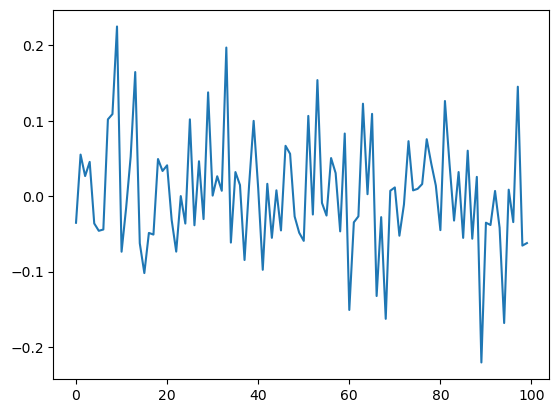

Training started...
Epoch 0: Train loss 15.764272689819336, Test loss 16.066205978393555.
Epoch 100: Train loss 0.011345689184963703, Test loss 0.011219861917197704.
Epoch 200: Train loss 0.002716674702242017, Test loss 0.0027506558690220118.
Epoch 300: Train loss 0.0012619984336197376, Test loss 0.0012713319156318903.
Epoch 400: Train loss 0.0007441419293172657, Test loss 0.0007587486179545522.
Epoch 500: Train loss 0.0005296344170346856, Test loss 0.00052602868527174.
Epoch 600: Train loss 0.0004064737004227936, Test loss 0.0004032868891954422.
Epoch 700: Train loss 0.00033095202525146306, Test loss 0.00032944511622190475.
Epoch 800: Train loss 0.00027585658244788647, Test loss 0.0002812762395478785.
Epoch 900: Train loss 0.00022224124404601753, Test loss 0.000227735101361759.
Epoch 1000: Train loss 0.0001967346470337361, Test loss 0.00020605046302080154.
Epoch 1100: Train loss 0.0001759592560119927, Test loss 0.0001859606127254665.
Epoch 1200: Train loss 0.0001538568176329136, Test 

In [ ]:
file = tf.io.read_file("../exps/demo4_train_test_data.txt")
train_test_data = tf.io.parse_tensor(file, out_type=tf.float32)
train_test_data = tf.random.shuffle(train_test_data)
train_data = train_test_data[:num_train, :]
test_data = train_test_data[num_train:, :]
plt.plot(train_data[:100, 0])
plt.show()
lhnn = LatentHamiltonianNeuralNetwork(3, 64, 5)
lhnn.build(input_shape=(1, 10))
train_hist, test_hist = lhnn.train(
    5000, 1000, 4e-5, train_data, test_data, save_dir="../exps/demo4_lhnn.weights.h5"
)

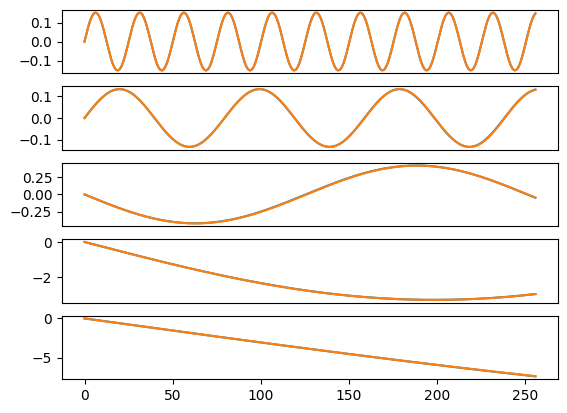

In [ ]:
lhnn = LatentHamiltonianNeuralNetwork(3, 64, 5)
lhnn.build(input_shape=(1, 10))
lhnn.load_weights("../exps/demo4_lhnn.weights.h5")
leap_frog_per_unit = 40
n_steps = 256
original_hamiltonian = HamiltonianSystem(U=U, K=K)

hist_original = original_hamiltonian.symplectic_integrate(
    q0, p0, 1 / leap_frog_per_unit, n_steps
)
hist_lhnn = lhnn.symplectic_integrate(q0, p0, 1 / leap_frog_per_unit, n_steps)

fig, ax = plt.subplots(5, 1)
ax[0].plot(hist_original[:, 0])
ax[0].plot(hist_lhnn[:, 0])
ax[1].plot(hist_original[:, 1])
ax[1].plot(hist_lhnn[:, 1])
ax[2].plot(hist_original[:, 2])
ax[2].plot(hist_lhnn[:, 2])
ax[3].plot(hist_original[:, 3])
ax[3].plot(hist_lhnn[:, 3])
ax[4].plot(hist_original[:, 4])
ax[4].plot(hist_lhnn[:, 4])
for i in range(4):
    ax[i].set_xticks([])
plt.show()

In [ ]:
q0 = tf.constant([[0.0, 0.0, 0.0, 0.0, 0.0]])
nuts = NoUTurnSampling(
    num_samples=25000,
    q0=q0,
    dt=0.025,
    lhnn=lhnn,
    Hamiltonian=HamiltonianSystem(U=U, K=K),
    Delta_lf=1000.0,
    Delta_lhnn=10.0,
    j_max=13,
)
nuts(print_every=2500)
print(nuts.lhnn_call)
print(nuts.Hamiltonian_gradient_call)
q_hist = tf.concat(nuts.q_hist, axis=0)
tf.io.write_file("../exps/demo4_q_hist.txt", tf.io.serialize_tensor(q_hist))
# plt.hist(q_hist.numpy()[5000:, 0].flatten(), bins=30, color="blue")
# plt.show()

Sampling finished 0 %
Sampling finished 10 %
Sampling finished 20 %
Sampling finished 30 %
Sampling finished 40 %
Sampling finished 50 %
Sampling finished 60 %
Sampling finished 70 %
Sampling finished 80 %
Sampling finished 90 %
Sampling finished 100 %


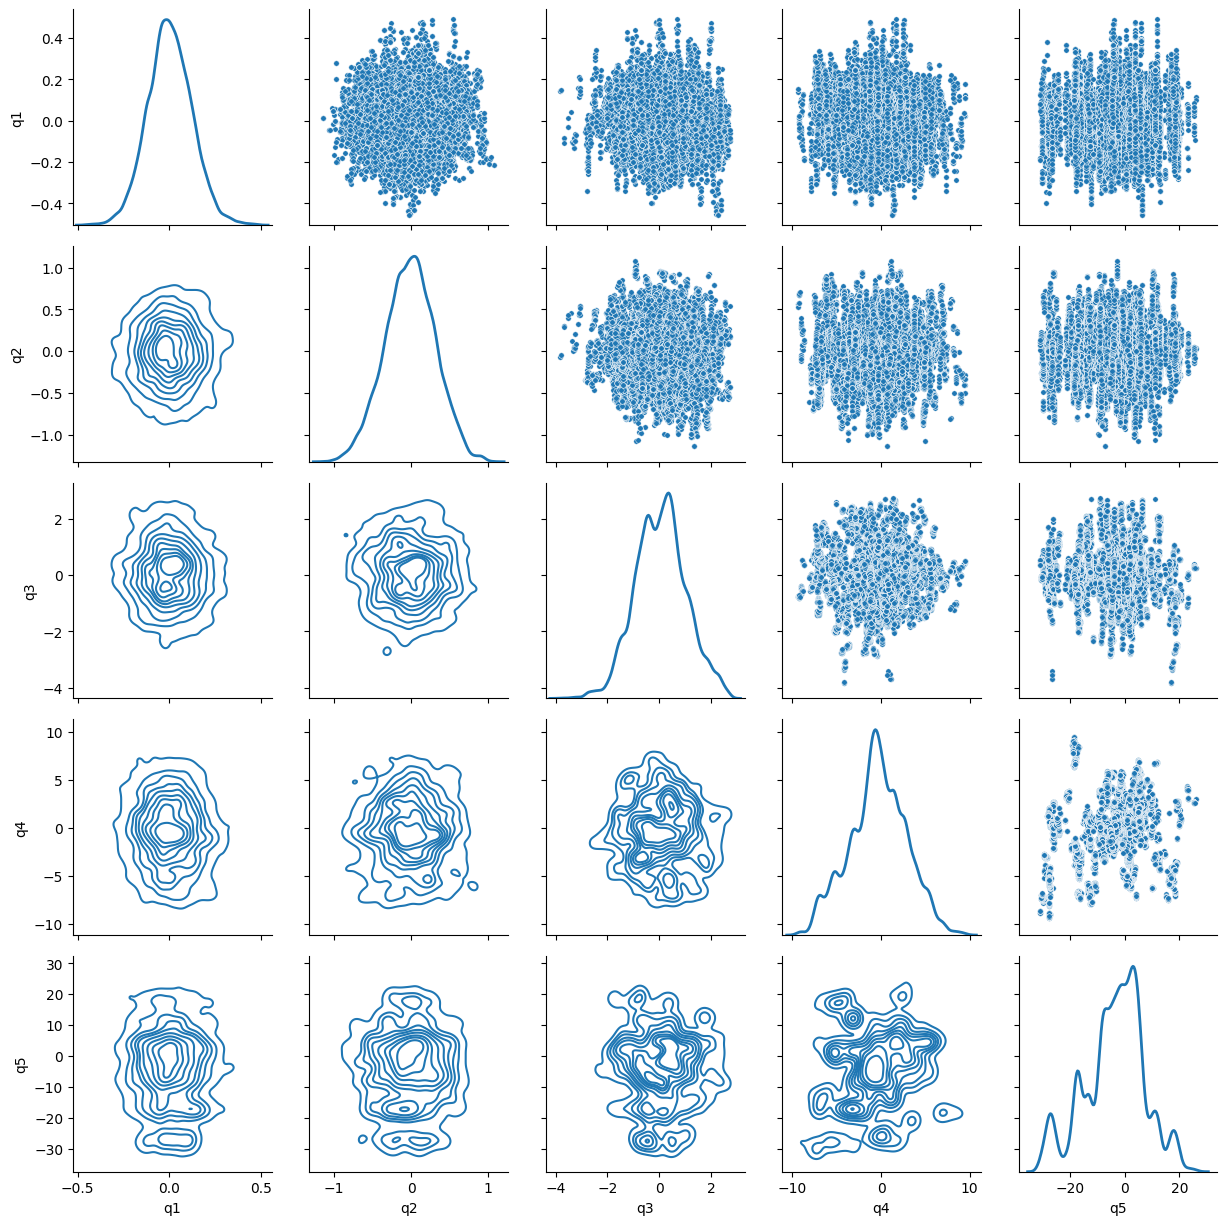

In [ ]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(q_hist.numpy()[5000:], columns=["q1", "q2", "q3", "q4", "q5"])
g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)